# Face-to-BMI
***
## Machine Learning II

By Amulya Jayanti | Halleluya Mengesha | Hira Stanley | Sami Naeem | Vaishnavi Kokadwar
  
*May, 2025*
***

# PART 2 - Models

## d) FaceNet

In [236]:
#!pip install facenet-pytorch scikit-learn pandas numpy
#!pip install catboost

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

In [238]:
df = pd.read_csv("BMI/Data/data.csv")
df.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


In [239]:
df.shape

(4206, 5)

In [240]:
df.columns

Index(['Unnamed: 0', 'bmi', 'gender', 'is_training', 'name'], dtype='object')

In [241]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [242]:
df.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


<Axes: xlabel='bmi', ylabel='Count'>

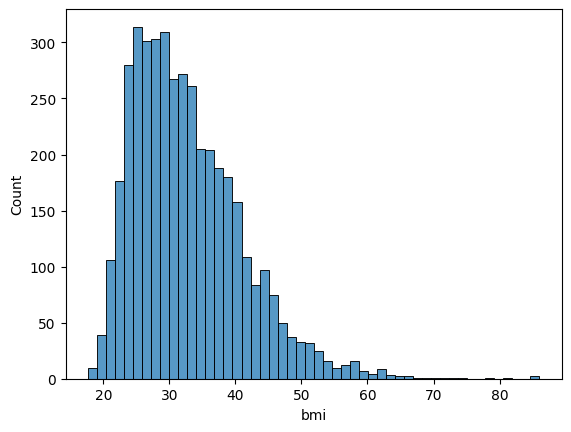

In [243]:
sns.histplot(data=df,x='bmi')

<Axes: xlabel='gender', ylabel='count'>

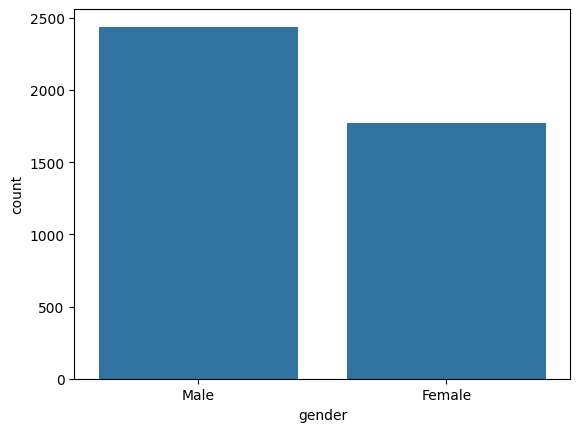

In [244]:
sns.countplot(data=df,x='gender')

<Axes: xlabel='bmi', ylabel='Count'>

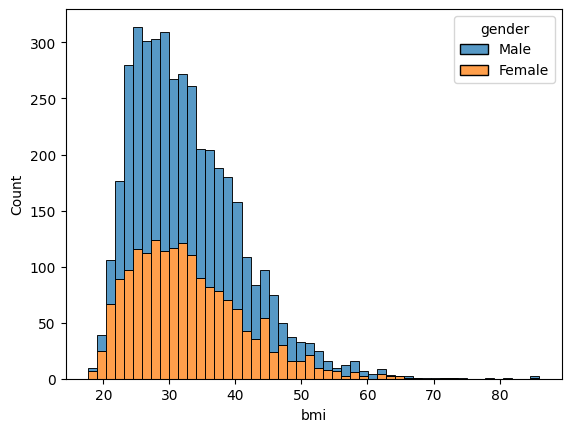

In [245]:
sns.histplot(data=df,x='bmi',hue='gender',multiple='stack')

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206 entries, 0 to 4205
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bmi          4206 non-null   float64
 1   gender       4206 non-null   object 
 2   is_training  4206 non-null   int64  
 3   name         4206 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 131.6+ KB


In [247]:
bmp_files = glob.glob('BMI/Data/Images/*.bmp')
print(bmp_files[0:5])

['BMI/Data/Images/img_1561.bmp', 'BMI/Data/Images/img_581.bmp', 'BMI/Data/Images/img_2068.bmp', 'BMI/Data/Images/img_3410.bmp', 'BMI/Data/Images/img_1207.bmp']


In [248]:
df = df[df['name'].apply(lambda x: 'BMI/Data/Images/' + x).isin(bmp_files)]
df.shape

(3962, 4)

In [249]:
df['is_training'].value_counts()

is_training
1    3210
0     752
Name: count, dtype: int64

In [250]:
df['is_training'].value_counts(normalize=True)

is_training
1    0.810197
0    0.189803
Name: proportion, dtype: float64

In [251]:
train = df[df["is_training"] == 1]
test = df[df["is_training"] == 0]

In [252]:
train.shape

(3210, 4)

In [253]:
test.shape

(752, 4)

In [254]:
train_paths = train["name"].tolist()
train_labels = train["bmi"].tolist()

val_paths = test["name"].tolist()
val_labels = test["bmi"].tolist()

# Initialize models

In [256]:
mtcnn = MTCNN(keep_all=True,image_size=160, margin=0, device='cpu')
resnet = InceptionResnetV1(pretrained='vggface2').eval()

def extract_face_embeddings(image_path):
    img = Image.open(image_path).convert('RGB')
    
    faces = mtcnn(img)  # ← Moved outside conditional

    if faces is None:
        return None

    # Take only first detected face
    if len(faces) > 0:
        face = faces[0].unsqueeze(0)  # Add batch dimension
        embedding = resnet(face)
        return embedding.detach().numpy().flatten()
    
    return None

In [257]:
# Extract embeddings for all images
embeddings_train = []

for idx, row in train.iterrows():
    emb = extract_face_embeddings('BMI/Data/Images/'+ row['name'])
    embeddings_train.append(emb)

In [258]:
# Extract embeddings for all images
embeddings_test = []

for idx, row in test.iterrows():
    emb = extract_face_embeddings('BMI/Data/Images/'+ row['name'])
    embeddings_test.append(emb)

In [259]:
y_train, y_test = train['bmi'], test['bmi']

In [260]:
# Get shapes of all embeddings (skip None values)
shapes = [emb.shape for emb in embeddings_train if emb is not None]

# Count unique shapes
shape_counts = Counter(shapes)
print("Embedding shapes:", shape_counts)

Embedding shapes: Counter({(512,): 3204})


In [261]:
# Find indices of embeddings with non-standard shapes
bad_indices_train = [i for i, emb in enumerate(embeddings_train) 
               if emb is None or emb.shape != (512,)]

print(f"Found {len(bad_indices_train)} invalid embeddings:")
print("Sample bad indices:", bad_indices_train[:5])  # First 5 problematic cases

Found 6 invalid embeddings:
Sample bad indices: [56, 74, 141, 946, 1006]


In [262]:
good_indices_train = [i for i in range(len(embeddings_train)) if i not in bad_indices_train]
embeddings_train = [embeddings_train[i] for i in good_indices_train]

In [263]:
y_train = y_train.drop(labels=bad_indices_train)

In [264]:
# Find indices of embeddings with non-standard shapes
bad_indices_test = [i for i, emb in enumerate(embeddings_test) 
               if emb is None or emb.shape != (512,)]

print(f"Found {len(bad_indices_test)} invalid embeddings:")
print("Sample bad indices:", bad_indices_test[:5])  # First 5 problematic cases

Found 2 invalid embeddings:
Sample bad indices: [140, 215]


In [265]:
good_indices_test = [i for i in range(len(embeddings_test)) if i not in bad_indices_test]
embeddings_test = [embeddings_test[i] for i in good_indices_test]

In [266]:
labels_to_drop = y_test.index[bad_indices_test]
y_test = y_test.drop(labels_to_drop)

In [267]:
embeddings_train_array = np.array(embeddings_train)
embeddings_test_array = np.array(embeddings_test)
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [300]:
normalizer = Normalizer(norm='l2')
embeddings_train_array = normalizer.fit_transform(embeddings_train_array)
embeddings_test_array = normalizer.transform(embeddings_test_array)

In [302]:
np.savetxt("train.csv", embeddings_train_array, delimiter=",")
np.savetxt("test.csv", embeddings_test_array, delimiter=",")

# Neural Networks for Regressor

In [63]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(512,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer="RMSprop", loss="mean_absolute_error")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

model.fit(x=embeddings_train_array,y=y_train_array,epochs=30,callbacks=early_stopping,validation_split=0.25)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 18.1990 - val_loss: 6.6906
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8261 - val_loss: 5.6918
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2091 - val_loss: 5.6820
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2685 - val_loss: 7.1337
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1844 - val_loss: 5.5667
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9561 - val_loss: 5.8452
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9951 - val_loss: 6.2839
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9767 - val_loss: 5.9251
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8646 - val_loss: 5.6897
Epoch 10/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9563 - val_loss: 6.2096


In [65]:
pred_v1 = model.predict(embeddings_test_array)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [427]:
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))


In [102]:
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))

rmse_value = rmse(pred_v1, y_test)
mae_value = mean_absolute_error(pred_v1, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v1).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.7576445677175965
MAE: 5.48839782479601
Pearson r = 0.556


# Fine-tuning Facenet

In [111]:
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1

# Load pretrained base
base_model = InceptionResnetV1(pretrained='vggface2', classify=False)

# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze last few layers
for name, param in base_model.last_linear.named_parameters():
    param.requires_grad = True
for name, module in base_model.named_modules():
    if 'block8' in name:
        for param in module.parameters():
            param.requires_grad = True

# Regression head
regression_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 1)  # FaceNet outputs 512-dim embeddings
)

model = FaceBmiRegressor(base_model, regression_head)
#model = model.to(device)

In [113]:
import torch
import torch.nn as nn

class FaceBmiRegressor(nn.Module):
    def __init__(self, base_model, regression_head):
        super(FaceBmiRegressor, self).__init__()
        self.base = base_model
        self.regressor = regression_head

    def forward(self, x):
        x = self.base(x)
        x = self.regressor(x)
        return x


In [123]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os

class FaceBmiDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['name'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        bmi = torch.tensor(self.data.iloc[idx]['bmi'], dtype=torch.float32)
        return image, bmi


In [137]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

train_dataset = FaceBmiDataset(train_df, 'BMI/Data/Images/')
val_dataset = FaceBmiDataset(val_df, 'BMI/Data/Images/')
test_dataset = FaceBmiDataset(test, 'BMI/Data/Images/')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceBmiRegressor(base_model, regression_head).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

# Training loop
for epoch in range(10):
    # Training phase
    model.train()
    running_loss = 0
    for images, bmis in train_loader:
        images, bmis = images.to(device), bmis.to(device).view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, bmis)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, bmis in val_loader:
            images, bmis = images.to(device), bmis.to(device).view(-1, 1)
            outputs = model(images)
            loss = loss_fn(outputs, bmis)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1 | Train Loss: 29.3293 | Val Loss: 28.6630
Epoch 2 | Train Loss: 29.1535 | Val Loss: 28.6912
Epoch 3 | Train Loss: 29.0522 | Val Loss: 28.5964
Epoch 4 | Train Loss: 28.9081 | Val Loss: 28.1457
Epoch 5 | Train Loss: 28.6531 | Val Loss: 28.3071
Epoch 6 | Train Loss: 28.5470 | Val Loss: 27.8513
Epoch 7 | Train Loss: 28.2974 | Val Loss: 27.6335
Epoch 8 | Train Loss: 28.1173 | Val Loss: 27.4520
Epoch 9 | Train Loss: 27.9259 | Val Loss: 27.3832
Epoch 10 | Train Loss: 27.8629 | Val Loss: 27.4793


In [143]:
model.eval()  # Set model to eval mode
predictions = []
true_bmis = []

with torch.no_grad():
    for images, bmis in test_loader:
        images = images.to(device)
        outputs = model(images)  # Forward pass
        predictions.extend(outputs.cpu().squeeze().tolist())  # Convert to list
        true_bmis.extend(bmis.tolist())  # Ground truth

# Now `predictions` and `true_bmis` are Python lists of predicted and actual BMI values

In [144]:
import pandas as pd

results_df = pd.DataFrame({
    'true_bmi': true_bmis,
    'predicted_bmi': predictions
})

# View a few predictions
print(results_df.head())

    true_bmi  predicted_bmi
0  29.698496       5.396646
1  30.845919       5.405897
2  24.389795       5.397714
3  36.258678       5.404206
4  27.891291       5.406070


In [152]:
# Non Fine Tuned Facenet with Regressor Head

# Random Forest Regressor

In [104]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(embeddings_train_array, y_train_array)

RandomForestRegressor()

In [105]:
pred_v2 = rf.predict(embeddings_test_array)

In [106]:
rmse_value = rmse(pred_v2, y_test)
mae_value = mean_absolute_error(pred_v2, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v2).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.914498521471157
MAE: 5.713518011702808
Pearson r = 0.549


# Ridge Regressor

In [108]:
rr = Ridge(alpha=1.0)
rr.fit(embeddings_train_array, y_train_array)

Ridge()

In [110]:
pred_v3 = rr.predict(embeddings_test_array)

In [112]:
rmse_value = rmse(pred_v3, y_test)
mae_value = mean_absolute_error(pred_v3, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v3).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.6578072646890964
MAE: 5.522296529810299
Pearson r = 0.572


# MLP Regressor

In [115]:
mlp = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=500, random_state=42)
mlp.fit(embeddings_train_array, y_train_array)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=500, random_state=42)

In [116]:
pred_v4 = mlp.predict(embeddings_test_array)

In [117]:
rmse_value = rmse(pred_v4, y_test)
mae_value = mean_absolute_error(pred_v4, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v4).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.882927940462315
MAE: 5.604630689673753
Pearson r = 0.535


# Light GBM Regressor

In [119]:
lgb = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb.fit(embeddings_train_array, y_train_array)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 3204, number of used features: 512
[LightGBM] [Info] Start training from score 32.427787


LGBMRegressor(random_state=42)

In [120]:
pred_v5 = lgb.predict(embeddings_test_array)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [121]:
rmse_value = rmse(pred_v5, y_test)
mae_value = mean_absolute_error(pred_v5, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v5).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.778654651572914
MAE: 5.6046208401762705
Pearson r = 0.549


# CatBoost Regressor

In [123]:
cat = CatBoostRegressor(iterations=100, verbose=0, random_seed=42)
cat.fit(embeddings_train_array, y_train_array)

In [124]:
pred_v6 = cat.predict(embeddings_test_array)

In [125]:
rmse_value = rmse(pred_v6, y_test)
mae_value = mean_absolute_error(pred_v6, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v6).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 8.157055789517804
MAE: 5.9219165579947735
Pearson r = 0.482


# Support Vector Regressor

In [127]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(embeddings_train_array, y_train_array)

SVR()

In [128]:
pred_v7 = svr.predict(embeddings_test_array)

In [129]:
rmse_value = rmse(pred_v7, y_test)
mae_value = mean_absolute_error(pred_v7, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v7).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.870662480672083
MAE: 5.523960205171088
Pearson r = 0.580


# KNN Regressor

In [131]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(embeddings_train_array, y_train_array)

KNeighborsRegressor()

In [132]:
pred_v8 = knn.predict(embeddings_test_array)

/opt/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [133]:
rmse_value = rmse(pred_v8, y_test)
mae_value = mean_absolute_error(pred_v8, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v8).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 8.57444257843345
MAE: 6.437121257584639
Pearson r = 0.396


# XGBoost Regressor

xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, random_state=42)
xgb.fit(embeddings_train_array, y_train_array)

pred_v9 = xgb.predict(embeddings_test_array)

rmse_value = rmse(pred_v9, y_test)
print("RMSE:", rmse_value)

Including gender

In [409]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
gender_train = le.fit_transform(train['gender'])  # male=1, female=0 (or vice versa)
gender_test = le.transform(test['gender'])


In [411]:
gender_train = gender_train.reshape(-1, 1)  # ensure 2D
gender_test = gender_test.reshape(-1, 1)


In [413]:
gender_train = [gender_train[i] for i in good_indices_train]
gender_test = [gender_test[i] for i in good_indices_test]

In [415]:
X_train = np.concatenate([embeddings_train_array, gender_train], axis=1)
X_test = np.concatenate([embeddings_test_array, gender_test], axis=1)


In [417]:
input_dim = X_train.shape[1]  # 513 if binary gender, 514 if one-hot

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [421]:
model.compile(optimizer="RMSprop", loss="mean_absolute_error")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

model.fit(x=X_train, y=y_train_array, epochs=20, callbacks=[early_stopping], validation_split=0.25)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 16.8319 - val_loss: 7.1340
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6688 - val_loss: 6.1029
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3456 - val_loss: 6.1067
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3174 - val_loss: 6.3015
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0455 - val_loss: 6.2832
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1506 - val_loss: 5.6916
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0845 - val_loss: 6.1221
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0671 - val_loss: 6.4826
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9278 - val_loss: 5.8043
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7486 - val_loss: 7.1626
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1001 - val_loss: 6.7341


In [423]:
pred_v1 = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [429]:
rmse_value = rmse(pred_v1, y_test)
mae_value = mean_absolute_error(pred_v1, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v1).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 8.763436224429682
MAE: 6.147540009022681
Pearson r = 0.520


In [435]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train_array)

RandomForestRegressor()

In [436]:
pred_v2 = rf.predict(X_test)

In [437]:
rmse_value = rmse(pred_v2, y_test)
mae_value = mean_absolute_error(pred_v2, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v2).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.9130161714856255
MAE: 5.718947021349286
Pearson r = 0.546


# Ridge Regressor

In [438]:
rr = Ridge(alpha=1.0)
rr.fit(X_train, y_train_array)

Ridge()

In [439]:
pred_v3 = rr.predict(X_test)

In [440]:
rmse_value = rmse(pred_v3, y_test)
mae_value = mean_absolute_error(pred_v3, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v3).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.656330185519985
MAE: 5.519017168248982
Pearson r = 0.572


# MLP Regressor

In [441]:
mlp = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=500, random_state=42)
mlp.fit(X_train, y_train_array)

MLPRegressor(max_iter=500, random_state=42)

In [442]:
pred_v4 = mlp.predict(X_test)

In [443]:
rmse_value = rmse(pred_v4, y_test)
mae_value = mean_absolute_error(pred_v4, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v4).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.803031561393245
MAE: 5.556168589033545
Pearson r = 0.542


# Light GBM Regressor

In [453]:
lgb = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb.fit(X_train, y_train_array)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130562
[LightGBM] [Info] Number of data points in the train set: 3204, number of used features: 513
[LightGBM] [Info] Start training from score 32.427787


LGBMRegressor(random_state=42)

In [454]:
pred_v5 = lgb.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [455]:
rmse_value = rmse(pred_v5, y_test)
mae_value = mean_absolute_error(pred_v5, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v5).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.778654651572914
MAE: 5.6046208401762705
Pearson r = 0.549


# CatBoost Regressor

In [457]:
cat = CatBoostRegressor(iterations=100, verbose=0, random_seed=42)
cat.fit(X_train, y_train_array)

In [458]:
pred_v6 = cat.predict(X_test)

In [459]:
rmse_value = rmse(pred_v6, y_test)
mae_value = mean_absolute_error(pred_v6, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v6).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 8.083880217342358
MAE: 5.810379253254928
Pearson r = 0.495


# Support Vector Regressor

In [461]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train_array)

SVR()

In [462]:
pred_v7 = svr.predict(X_test)

In [463]:
rmse_value = rmse(pred_v7, y_test)
mae_value = mean_absolute_error(pred_v7, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v7).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 7.908527785967788
MAE: 5.542489336443708
Pearson r = 0.574


# KNN Regressor

In [465]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train_array)

KNeighborsRegressor()

In [466]:
pred_v8 = knn.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [467]:
rmse_value = rmse(pred_v8, y_test)
mae_value = mean_absolute_error(pred_v8, y_test)
print("RMSE:", rmse_value)
print("MAE:", mae_value)
r, _ = pearsonr(np.array(y_test).flatten(), np.array(pred_v8).flatten())
print(f"Pearson r = {r:.3f}")

RMSE: 8.653168334895353
MAE: 6.474736838829252
Pearson r = 0.380


In [482]:
#Prediction pipeline

In [ ]:
path = ""

def predict_bmi(path):
    emb = extract_face_embeddings(path)    
    y_test_array = np.array(y_test)
    embeddings_test_array = normalizer.transform(embeddings_test_array)
    pred_v1 = model.predict(embeddings_test_array)
